# Make Photoz test input from VIDEO SXDS data

This notebook uses the HELP python environment to make a eazy-pype input catalogue:

https://github.com/H-E-L-P/herschelhelp_internal

To make the photoz inputs we must merge in the spectroscopic redshifts and make some trivial catalogue changes. We then need to make configuration inputs for the photoz code. This includes downloading filter response curves.

Installation and running of the EAZY based code is described here:

https://github.com/dunkenj/eazy-pype/

This is an early test on the catalogues as part of our validation process.



In [1]:
# What version of the Stack are we using?
! eups list -s | grep lsst_distrib
! eups list -s | grep obs_vista

lsst_distrib          g2d4714e03a+6e1aa0b536 	current w_latest w_2022_07 setup
obs_vista             23.0.0-1   	current setup


In [2]:

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
from herschelhelp.filters import correct_galactic_extinction
from herschelhelp.external import convert_table_for_cigale
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc, mag_to_flux

import numpy as np
import os
import time

from astropy.time import Time
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord

from collections import OrderedDict

/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam wa

In [3]:
#SUFFIX = os.environ.get('SUFFIX', time.strftime("%Y%m%d"))
SUFFIX=Time.now().isot.replace(':','').replace('-','')[:-4]

In [4]:
SUFFIX

'20220803T140245'

In [5]:
!mkdir figs

mkdir: figs: File exists


In [6]:
!ls ../../dmu5/dmu5_VIDEO/data/

3.0_startCoadd.slurm.e58711243
39
48
66
8523_5,2_reducedCat.fits
VSA_Ks_6.fits
calexp-HSC-R-8524-2,7.fits
calexp-VISTA-Y-8524-2,7.fits
deepCoadd_calexp_8524_48_K_hscPdr2_u_ir-shir1_DRP_videoCoaddDetect_20220405T133706Z.fits
deepCoadd_calexp_8524_48_K_hscPdr2_u_ir-shir1_DRP_videoCoaddDetect_20220720T183849Z.fits
deepCoadd_calexp_8524_48_K_hscPdr2_u_ir-shir1_DRP_videoCoadd_20220411T145237Z.fits
example
full_reduced_cat_SXDS_20220802.fits
full_reduced_cat_SXDS_p2021_1.fits
full_reduced_cat_SXDS_p2021_1_20210702.fits
full_reduced_cat_SXDS_p2022.1_20220428.fits
full_reduced_cat_SXDS_p2022.1_20220721.fits.gz
u_ir-shir1_DRP_singleFrame_20220317T193549Z_2022-03-17_21:12.png
u_ir-shir1_DRP_videoCoadd_20220407T164547Z_2022-04-07_18:40.png
u_ir-shir1_DRP_videoCoadd_20220411T145237Z_2022-04-11_16:55.png
u_ir-shir1_DRP_videoCoadd_20220411T145237Z_2022-04-13_16:09.png
u_ir-shir1_DRP_videoMultiVisit3_20220420T134201Z_2022-04-20_14:49.png


In [7]:
#choose version
#version='p2021.1'
#infile ='../../dmu5/dmu5_VIDEO/data/full_reduced_cat_SXDS_p2021_1_20210702.fits'

# version='p2022p3'
# infile='../../dmu5/dmu5_VIDEO/data/full_reduced_cat_SXDS_20220802.fits'

version='oxford'
infile = "../../dmu3/data/XMMFULL_DR2_MASKVISTA_Ks_2.0as_IRAC2.8as_2020_06_01.fits"

hsc_bands = 'GRIZY'
vista_bands = 'ZYJHK'# removing ZY for now
bands = ['HSC_{}'.format(b) for b in hsc_bands]
bands += ['VIRCAM_{}'.format(b) for b in vista_bands]
    
if version.startswith('p202'):

    cols = ['id', 'VIRCAM_Ks_m_coord_ra','VIRCAM_Ks_m_coord_dec','VIRCAM_Ks_m_detect_isPrimary']
    cols+=['{}_m_base_CircularApertureFlux_6_0_flux'.format(b.replace('K','Ks')) for b in bands]
    cols+=['{}_m_base_CircularApertureFlux_6_0_fluxErr'.format(b.replace('K','Ks'))  for b in bands]
    cat = Table.read(infile)[cols]
    cat['ra']=cat['VIRCAM_Ks_m_coord_ra'] #.name='ra'
    cat['dec']=cat['VIRCAM_Ks_m_coord_dec'] #.name='dec'

    for c in cat.colnames:
        cat[c].name=c.replace('VISTA','VIRCAM')

In [8]:
if version=='oxford':
    imported_columns = OrderedDict({
            'ID_se':              'id', 
            'RA':     'ra', 
            'DEC':     'dec', 

            #'J_CLASS_STAR':    'vista_stellarity', 
            'flux_HSC-G':    'f_ap_hsc_g', 
            'err_HSC-G':     'ferr_ap_hsc_g',
            'flux_HSC-R':    'f_ap_hsc_r', 
            'err_HSC-R':     'ferr_ap_hsc_r',
            'flux_HSC-I':    'f_ap_hsc_i', 
            'err_HSC-I':     'ferr_ap_hsc_i',
            'flux_HSC-Z':    'f_ap_hsc_z', 
            'err_HSC-Z':     'ferr_ap_hsc_z',
            'flux_HSC-Y':    'f_ap_hsc_y', 
            'err_HSC-Y':     'ferr_ap_hsc_y',

            'flux_Z':    'f_ap_vircam_z', 
            'err_Z': 'ferr_ap_vircam_z', 

            'flux_Y':    'f_ap_vircam_y', 
            'err_Y': 'ferr_ap_vircam_y', 


            'flux_J':    'f_ap_vircam_j', 
            'err_J': 'ferr_ap_vircam_j', 


            'flux_H':    'f_ap_vircam_h', 
            'err_H': 'ferr_ap_vircam_h', 


            'flux_Ks':    'f_ap_vircam_ks', 
            'err_Ks': 'ferr_ap_vircam_ks', 


    })


    oxford_ks_cat = Table.read(infile
                          )[list(imported_columns)]


    for column in imported_columns:
        oxford_ks_cat[column].name = 'oxford_ks_' + imported_columns[column]



    oxford_ks_cat['oxford_ks_ra'].unit = u.deg
    oxford_ks_cat['oxford_ks_dec'].unit = u.deg
    oxford_ks_cat['oxford_ks_ra'].convert_unit_to(u.rad)
    oxford_ks_cat['oxford_ks_dec'].convert_unit_to(u.rad)
    oxford_ks_cat['ra'] = oxford_ks_cat['oxford_ks_ra']
    oxford_ks_cat['dec'] = oxford_ks_cat['oxford_ks_dec']
    print(len(oxford_ks_cat))

    for col in oxford_ks_cat.colnames:
        if col.startswith('oxford_ks_f_'):
            err_col = col.replace('_f_', '_ferr_')
            oxford_ks_cat[col].unit = u.erg/u.second/u.cm**2/u.Hz
            oxford_ks_cat[err_col].unit = u.erg/u.second/u.cm**2/u.Hz
            oxford_ks_cat[col].convert_unit_to(u.uJy)
            oxford_ks_cat[err_col].convert_unit_to(u.uJy)
            # m,merr = flux_to_mag(oxford_ks_cat[col]*1e-6,oxford_ks_cat[err_col]*1e-6) # expects Jansky
            # oxford_ks_cat[col.replace('_f_', '_m_')] = m
            # oxford_ks_cat[err_col.replace('_ferr_', '_merr_')] = merr
            # oxford_ks_cat.remove_columns([col,err_col])

    for col in oxford_ks_cat.colnames:
        if col.startswith('oxford_ks_f_ap_'):
            errcol=col.replace('_f_ap','_ferr_ap')
            mask = oxford_ks_cat[col]<-1e30
            oxford_ks_cat[col][mask] = np.nan
            oxford_ks_cat[errcol][mask] = np.nan

    for c in oxford_ks_cat.colnames:
        if c.startswith('oxford_ks_f_ap'):
            errcol=c.replace('_f_ap','_ferr_ap')
            oxford_ks_cat[c].convert_unit_to(u.nJy)
            oxford_ks_cat[errcol].convert_unit_to(u.nJy)
            physical_filter = c.split('_')[4].upper()+'_'+c.split('_')[5]
            physical_filter=physical_filter.upper()
            physical_filter=physical_filter.replace('KS','Ks')
            oxford_ks_cat[c].name='{}_m_base_CircularApertureFlux_6_0_flux'.format(physical_filter)
            oxford_ks_cat[errcol].name='{}_m_base_CircularApertureFlux_6_0_fluxErr'.format(physical_filter)



    oxford_ks_cat['oxford_ks_id'].name='id'
    oxford_ks_cat['oxford_ks_ra'].name='VIRCAM_Ks_m_coord_ra'
    oxford_ks_cat['oxford_ks_dec'].name='VIRCAM_Ks_m_coord_dec'
    oxford_ks_cat['VIRCAM_Ks_m_detect_isPrimary']=np.full(len(oxford_ks_cat),1)
    cat=oxford_ks_cat

1674689


In [9]:
cat[:5]

id,VIRCAM_Ks_m_coord_ra,VIRCAM_Ks_m_coord_dec,HSC_G_m_base_CircularApertureFlux_6_0_flux,HSC_G_m_base_CircularApertureFlux_6_0_fluxErr,HSC_R_m_base_CircularApertureFlux_6_0_flux,HSC_R_m_base_CircularApertureFlux_6_0_fluxErr,HSC_I_m_base_CircularApertureFlux_6_0_flux,HSC_I_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Z_m_base_CircularApertureFlux_6_0_flux,HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Y_m_base_CircularApertureFlux_6_0_flux,HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_flux,VIRCAM_J_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_flux,VIRCAM_H_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr,ra,dec,VIRCAM_Ks_m_detect_isPrimary
,rad,rad,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,rad,rad,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
610230,0.5907544,-0.0740255,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1430.384,106.94841100553694,1546.424,140.12018155694798,1661.139,268.4761265560823,1432.295,429.13168548428877,1920.2684236581238,616.637195800575,0.5907544,-0.0740255,1
128492,0.5907544,-0.0930592,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,663.4863,118.41723233208064,638.1233,164.47815862953084,1063.842,271.8409718282581,739.292,416.8779724260516,1187.7521444594988,629.8319160860001,0.5907544,-0.0930592,1
451090,0.5907545,-0.0805257,43.68729,19.92552093466067,107.098,24.25664877078547,113.4454,32.182509373871675,288.9393,68.24581697177416,534.7465,140.82664857297104,376.0022,84.00015352253342,420.0927,137.4850907607348,1269.365,198.33777150881008,2039.601,351.29559591146625,2756.8595793601457,540.7771148629596,0.5907545,-0.0805257,1
173887,0.5907545,-0.0912285,122.9779,29.6769438788803,184.6491,33.626336500937626,183.7611,51.17070779591335,233.7077,70.66301382803753,455.9681,193.68117061672277,391.0208,94.42555770094235,344.8599,130.50123254972846,831.5019,207.02276282008424,445.0765,427.3224532622241,1418.240307129895,608.4441179812184,0.5907545,-0.0912285,1
69787,0.5907545,-0.0954864,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,7247.168,362.35841102641194,7110.14,355.5069768974026,8176.587,408.82936255764724,8794.508,482.85403299731087,11154.777001057402,571.5807580431524,0.5907545,-0.0954864,1


In [10]:
#From email from Manda
oxfordApCorr = {
    'HSC_G_2as':0.1765,
    'HSC_G_3as':0.0788,
    'HSC_R_2as':0.1638,
    'HSC_R_3as':0.0905,
    'HSC_I_2as':0.1512,
    'HSC_I_3as':0.0788,
    'HSC_Z_2as':0.2155,
    'HSC_Z_3as':0.1144,
    'HSC_Y_2as':0.2023,
    'HSC_Y_3as':0.1144,
    'VIRCAM_Z_2as':0.3567,
    'VIRCAM_Z_3as':0.2023,
    'VIRCAM_Y_2as':0.3567,
    'VIRCAM_Y_3as':0.2023,
    'VIRCAM_J_2as':0.2980,
    'VIRCAM_J_3as':0.1765,
    'VIRCAM_H_2as':0.2423,
    'VIRCAM_H_3as':0.1512,
    'VIRCAM_Ks_2as':0.2288,
    'VIRCAM_Ks_3as':0.1388}

In [11]:
for c in cat.colnames:
    if c.endswith('_mag'):
        #print(c)
        physical_filter='{}_{}'.format(c.split('_')[0],c.split('_')[1])
        #print(np.nanmedian(test_cat[c]))
        #Following correction once to fix issue with calibrators and twice to apply apperture corrections!
        if version=='p2021.1':
            if 'HSC' in physical_filter:
                cat[c]-=1*oxfordApCorr['{}_2as'.format(physical_filter)]
            elif 'VIRCAM' in physical_filter:
                cat[c]-=2*oxfordApCorr['{}_2as'.format(physical_filter)]
        elif version=='p2022p3':
            cat[c]-=1*oxfordApCorr['{}_2as'.format(physical_filter)]
        #print(np.nanmedian(test_cat[c]))
        #cat[c.replace('mag','flux')],cat[c.replace('mag','fluxErr')]=mag_to_flux(
         #   cat[c],cat[c.replace('mag','magErr')])
        
    if c.endswith('_flux') or c.endswith('_fluxErr'):
        #print(c)
        physical_filter='{}_{}'.format(c.split('_')[0],c.split('_')[1])
        #print(np.nanmedian(test_cat[c]))
        #Following correction once to fix issue with calibrators and twice to apply apperture corrections!
        if version.startswith('p202'):
            if 'HSC' in physical_filter:
                cat[c]*=10**(1*oxfordApCorr['{}_2as'.format(physical_filter)]/2.5)
                #print(c,physical_filter,oxfordApCorr['{}_2as'.format(physical_filter)])
            elif 'VIRCAM' in physical_filter:
                cat[c]*=10**(1*oxfordApCorr['{}_2as'.format(physical_filter)]/2.5)
                #print(c,physical_filter,2*oxfordApCorr['{}_2as'.format(physical_filter)])
                                                                                             

In [12]:
for b in bands:
    b=b.replace('VISTA','VIRCAM').replace('_K','_Ks')
    print(b)
    
    flux_col="{}_m_base_CircularApertureFlux_6_0_flux".format(b.replace('VISTA','VIRCAM'))
    err_col=flux_col+"Err"
    bad_meas=cat[flux_col]>1e10
    bad_meas|=cat[err_col]>1e10
    bad_meas|=cat[flux_col]<-1e10
    bad_meas|=cat[err_col]<-1e10
    print(np.sum(bad_meas),len(bad_meas))
    cat[flux_col][bad_meas]=np.nan
    cat[err_col][bad_meas]=np.nan
    
    #Try recalibrating errors
    if 'VIRCAM' in b:
        pass
        #cat[err_col]*=4

HSC_G
0 1674689
HSC_R
0 1674689
HSC_I
0 1674689
HSC_Z
0 1674689
HSC_Y
0 1674689
VIRCAM_Z
0 1674689
VIRCAM_Y
0 1674689
VIRCAM_J
0 1674689
VIRCAM_H
0 1674689
VIRCAM_Ks
0 1674689


In [13]:
# #Rename to CIGALE/HELP format
# for c in cat.colnames:
#     if c.endswith('m_base_CircularApertureFlux_6_0_flux'):
#         mask = cat[c]>1e10
#         cat[c][mask]=np.nan
#         f_name='{}_{}_flux'.format(
#             c.split('_')[0].lower(),#.replace('hsc','suprime'),
#             c.split('_')[1].lower()
#         )
#         cat[c].name=f_name
#         cat[f_name]=cat[f_name].to(u.uJy)
#     if c.endswith('m_base_CircularApertureFlux_6_0_fluxErr'):
#         mask = cat[c]>1e10
#         cat[c][mask]=np.nan
#         ferr_name='{}_{}_fluxerr'.format(
#             c.split('_')[0].lower(),#.replace('hsc','suprime'),
#             c.split('_')[1].lower()
#         )
#         cat[c].name=ferr_name
#         cat[ferr_name]=cat[ferr_name].to(u.uJy)

In [14]:
mask = (cat['ra']<1e10) | (cat['dec']<1e10)
mask&=cat['VIRCAM_Ks_m_detect_isPrimary']==1
#mask&=(cat['hsc_i_flux']/cat['hsc_i_fluxerr'] > 5)
#mask&=(cat['vista_ks_flux']/cat['vista_ks_fluxerr'] > 5)
cat = cat[mask]
    
cat['ra']=cat['ra'].to(u.deg)
cat['dec']=cat['dec'].to(u.deg)


In [15]:
#cat['zspec'].name='z_spec'

## Merge Specz

In [16]:
specz=Table.read('./data/XMM-LSS-specz-v2.91.fits.gz')
for c in specz.colnames:
    specz[c].name=c.lower()
specz['objid'].name='specz_id'

In [17]:
len(specz)

127682

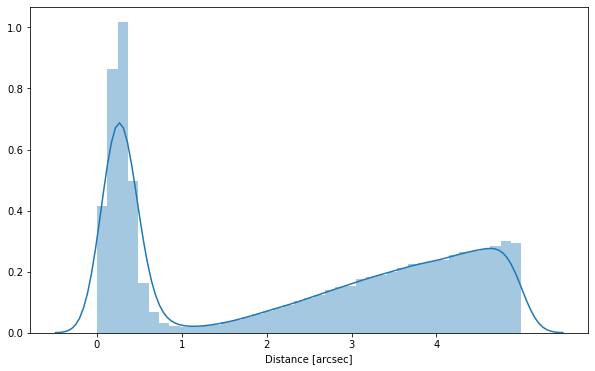

In [18]:
nb_merge_dist_plot(
    SkyCoord(cat['ra'], cat['dec']),
    SkyCoord(specz['ra'] * u.deg, specz['dec'] * u.deg)
)

In [19]:
cat = specz_merge(cat, specz, radius=1. * u.arcsec)

In [20]:
#cat=cat[cat['specz_id']!='']
#cat['redshift']=cat['zspec']

In [21]:
#Replace nans with -99
cat['zspec'].name='z_spec'
cat['z_spec'][np.isnan(cat['z_spec'])]=-99

In [22]:
#remove spaces from specz id
cat['specz_id'] = [s.replace(' ','') for s in cat['specz_id']]

In [23]:
#add int id col
#cat['id']=np.arange(len(cat))

In [24]:
len(cat)

1674689

Text(0.5, 0, 'HSC-I snr')

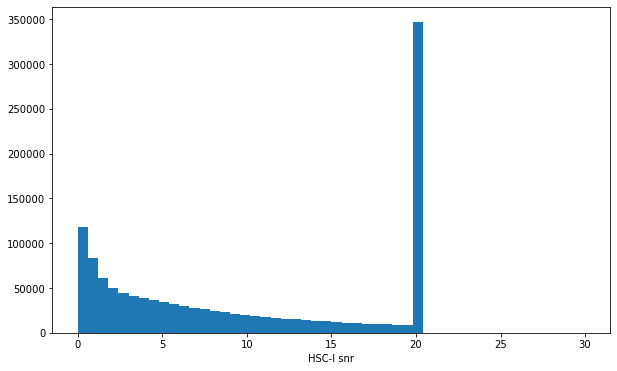

In [25]:
# hsc_i_flux,hsc_i_fluxerr=mag_to_flux(
#     cat['HSC_I_m_base_CircularApertureFlux_6_0_mag'],cat['HSC_I_m_base_CircularApertureFlux_6_0_magErr'])
hsc_i_flux,hsc_i_fluxerr=(
    cat['HSC_I_m_base_CircularApertureFlux_6_0_flux'],cat['HSC_I_m_base_CircularApertureFlux_6_0_fluxErr'])
plt.hist(hsc_i_flux/hsc_i_fluxerr,bins=50,range=[0,30])
plt.xlabel('HSC-I snr')

/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'log10(VIRCAM_Y)')

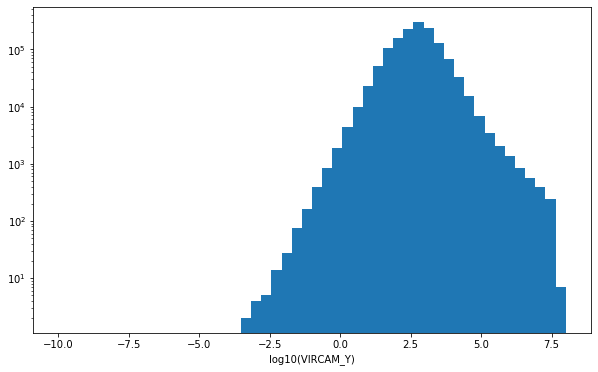

In [26]:
plt.hist(np.log10(cat['VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux']),bins=50,range=[-10,8])
plt.yscale('log')
plt.xlabel('log10(VIRCAM_Y)')

In [27]:
np.sum(cat['VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux']<0)

294090

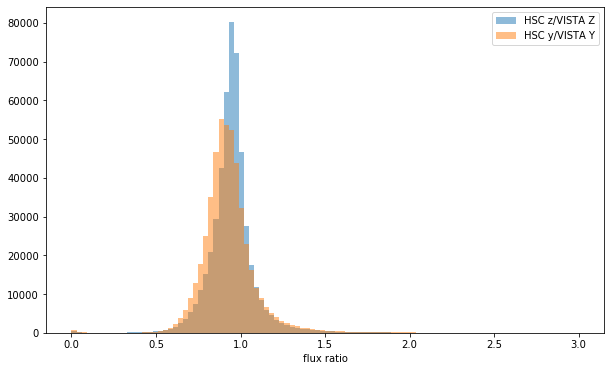

In [28]:
hsc_z_flux,hsc_z_fluxerr=(
    cat['HSC_Z_m_base_CircularApertureFlux_6_0_flux'],cat['HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr'])
vircam_z_flux,vircam_z_fluxerr=(
    cat['VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux'],cat['VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr'])
hsc_y_flux,hsc_y_fluxerr=(
    cat['HSC_Y_m_base_CircularApertureFlux_6_0_flux'],cat['HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr'])
vircam_y_flux,vircam_y_fluxerr=(
    cat['VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux'],cat['VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr'])
try:
    z_rat=hsc_z_flux/vircam_z_flux
    z_m=np.isfinite(z_rat) & (hsc_z_flux/hsc_z_fluxerr>5)
    y_rat=hsc_y_flux/vircam_y_flux
    y_m=np.isfinite(y_rat) & (hsc_y_flux/hsc_y_fluxerr>5)
    plt.hist(z_rat[z_m],bins=100,range=[0,3],alpha=0.5,label='HSC z/VISTA Z')
    plt.hist(y_rat[y_m],bins=100,range=[0,3],alpha=0.5,label='HSC y/VISTA Y')
    plt.xlabel('flux ratio')
    plt.legend()
    plt.savefig('./figs/flux_ratios_{}.png'.format(version))
except KeyError:
    print('No VISTA ZY bands')

/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


Text(0.5, 0, 'log10(SNR)')

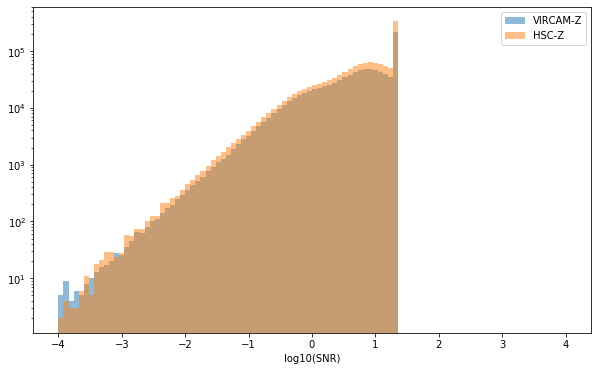

In [29]:
plt.hist(np.log10(vircam_z_flux/vircam_z_fluxerr),bins=100,alpha=0.5,label='VIRCAM-Z',range=[-4,4])
plt.hist(np.log10(hsc_z_flux/hsc_z_fluxerr),bins=100,alpha=0.5,label='HSC-Z',range=[-4,4])
plt.legend()
plt.yscale('log')
plt.xlabel('log10(SNR)')

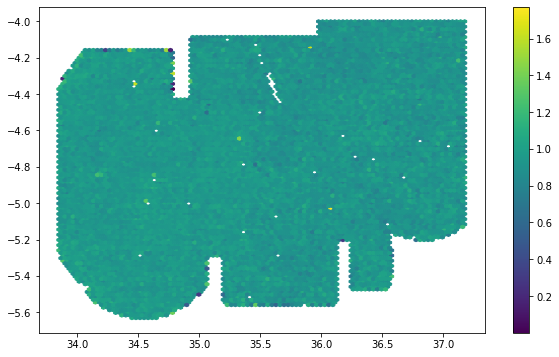

In [30]:
try:
    m=(y_rat>0) & (y_rat<3)
    plt.hexbin(cat[m]['ra'],cat[m]['dec'],C=y_rat[m], gridsize=100)
    plt.colorbar()
except NameError:
    print('No VISTA ZY bands')

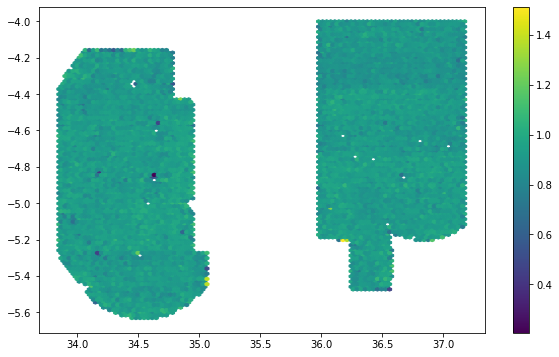

In [31]:
try:
    m=(z_rat>0) & (z_rat<3)
    plt.hexbin(cat[m]['ra'],cat[m]['dec'],C=z_rat[m], gridsize=100)
    plt.colorbar()
except NameError:
    print('No VISTA ZY bands')

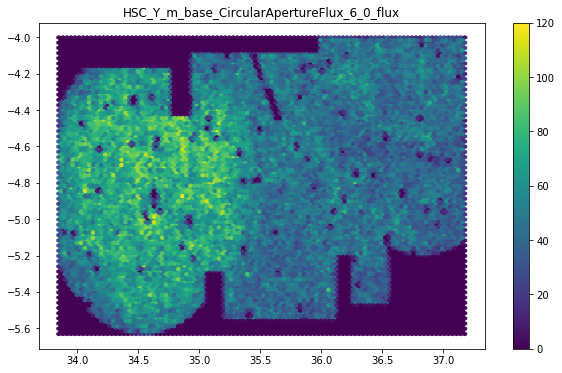

In [32]:
try:
    fluxCol='HSC_Y_m_base_CircularApertureFlux_6_0_flux'
    m=(cat[fluxCol]/cat[fluxCol.replace('flux','fluxErr')]>5) #& (cat[fluxCol]<30)
    plt.hexbin(cat[m]['ra'],cat[m]['dec'], gridsize=100)
    plt.colorbar()
    plt.title(fluxCol)
except NameError:
    print('No data')

## Add EBV column

This is used to correct for galactic extinction.

In [33]:
cat.add_column(
    ebv(cat['ra'], cat['dec'])
)

## Write catalogue

In [34]:
cat[:5]

id,VIRCAM_Ks_m_coord_ra,VIRCAM_Ks_m_coord_dec,HSC_G_m_base_CircularApertureFlux_6_0_flux,HSC_G_m_base_CircularApertureFlux_6_0_fluxErr,HSC_R_m_base_CircularApertureFlux_6_0_flux,HSC_R_m_base_CircularApertureFlux_6_0_fluxErr,HSC_I_m_base_CircularApertureFlux_6_0_flux,HSC_I_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Z_m_base_CircularApertureFlux_6_0_flux,HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Y_m_base_CircularApertureFlux_6_0_flux,HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_flux,VIRCAM_J_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_flux,VIRCAM_H_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr,ra,dec,VIRCAM_Ks_m_detect_isPrimary,specz_id,z_spec,zspec_qual,zspec_association_flag,ebv
,rad,rad,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,deg,deg,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str25,float64,int64,bool,float64
610230,0.5907544,-0.0740255,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1430.384,106.94841100553694,1546.424,140.12018155694798,1661.139,268.4761265560823,1432.295,429.13168548428877,1920.2684236581238,616.637195800575,33.84773504610634,-4.241351576266777,1,,-99.0,-99,False,0.017595750322663212
128492,0.5907544,-0.0930592,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,663.4863,118.41723233208064,638.1233,164.47815862953084,1063.842,271.8409718282581,739.292,416.8779724260516,1187.7521444594988,629.8319160860001,33.84773558758696,-5.331901648064479,1,,-99.0,-99,False,0.017807175433321554
451090,0.5907545,-0.0805257,43.68729,19.92552093466067,107.098,24.25664877078547,113.4454,32.182509373871675,288.9393,68.24581697177416,534.7465,140.82664857297104,376.0022,84.00015352253342,420.0927,137.4850907607348,1269.365,198.33777150881008,2039.601,351.29559591146625,2756.8595793601457,540.7771148629596,33.84773865115458,-4.61378377842162,1,,-99.0,-99,False,0.018599648451516744
173887,0.5907545,-0.0912285,122.9779,29.6769438788803,184.6491,33.626336500937626,183.7611,51.17070779591335,233.7077,70.66301382803753,455.9681,193.68117061672277,391.0208,94.42555770094235,344.8599,130.50123254972846,831.5019,207.02276282008424,445.0765,427.3224532622241,1418.240307129895,608.4441179812184,33.847740641886034,-5.227009191874247,1,,-99.0,-99,False,0.018120502422725355
69787,0.5907545,-0.0954864,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,7247.168,362.35841102641194,7110.14,355.5069768974026,8176.587,408.82936255764724,8794.508,482.85403299731087,11154.777001057402,571.5807580431524,33.8477420815543,-5.470964892675307,1,,-99.0,-99,False,0.017992270337493503


In [35]:
for c in cat.colnames:
    if c.endswith('flux'):
        m=np.array(~np.isfinite(cat[c]))
        m|=np.array(cat[c])>1e18
        cat[c][m]=np.nan
        cat[c+'Err'][m]=np.nan

In [36]:
cat[0:5]

id,VIRCAM_Ks_m_coord_ra,VIRCAM_Ks_m_coord_dec,HSC_G_m_base_CircularApertureFlux_6_0_flux,HSC_G_m_base_CircularApertureFlux_6_0_fluxErr,HSC_R_m_base_CircularApertureFlux_6_0_flux,HSC_R_m_base_CircularApertureFlux_6_0_fluxErr,HSC_I_m_base_CircularApertureFlux_6_0_flux,HSC_I_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Z_m_base_CircularApertureFlux_6_0_flux,HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Y_m_base_CircularApertureFlux_6_0_flux,HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_flux,VIRCAM_J_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_flux,VIRCAM_H_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr,ra,dec,VIRCAM_Ks_m_detect_isPrimary,specz_id,z_spec,zspec_qual,zspec_association_flag,ebv
,rad,rad,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,deg,deg,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str25,float64,int64,bool,float64
610230,0.5907544,-0.0740255,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1430.384,106.94841100553694,1546.424,140.12018155694798,1661.139,268.4761265560823,1432.295,429.13168548428877,1920.2684236581238,616.637195800575,33.84773504610634,-4.241351576266777,1,,-99.0,-99,False,0.017595750322663212
128492,0.5907544,-0.0930592,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,663.4863,118.41723233208064,638.1233,164.47815862953084,1063.842,271.8409718282581,739.292,416.8779724260516,1187.7521444594988,629.8319160860001,33.84773558758696,-5.331901648064479,1,,-99.0,-99,False,0.017807175433321554
451090,0.5907545,-0.0805257,43.68729,19.92552093466067,107.098,24.25664877078547,113.4454,32.182509373871675,288.9393,68.24581697177416,534.7465,140.82664857297104,376.0022,84.00015352253342,420.0927,137.4850907607348,1269.365,198.33777150881008,2039.601,351.29559591146625,2756.8595793601457,540.7771148629596,33.84773865115458,-4.61378377842162,1,,-99.0,-99,False,0.018599648451516744
173887,0.5907545,-0.0912285,122.9779,29.6769438788803,184.6491,33.626336500937626,183.7611,51.17070779591335,233.7077,70.66301382803753,455.9681,193.68117061672277,391.0208,94.42555770094235,344.8599,130.50123254972846,831.5019,207.02276282008424,445.0765,427.3224532622241,1418.240307129895,608.4441179812184,33.847740641886034,-5.227009191874247,1,,-99.0,-99,False,0.018120502422725355
69787,0.5907545,-0.0954864,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,7247.168,362.35841102641194,7110.14,355.5069768974026,8176.587,408.82936255764724,8794.508,482.85403299731087,11154.777001057402,571.5807580431524,33.8477420815543,-5.470964892675307,1,,-99.0,-99,False,0.017992270337493503


In [37]:
np.sum(cat['zspec_qual']>0)

81988

In [38]:
np.sum(cat['zspec_qual']>=4 )/np.sum(cat['zspec_qual']>0)

0.22192272039810704

In [39]:
np.sum(cat['zspec_qual']>=3 )/np.sum(cat['zspec_qual']>0)

0.5587159096453139

In [40]:
SUFFIX

'20220803T140245'

In [41]:
# n='./data/lsst_ir_fusion_sxds_photoz_input_{}.fits'.format(SUFFIX)
# cat.write(n,overwrite=True)
# print(n)

In [42]:
len(cat),np.sum(cat['z_spec']>=0)

(1674689, 80836)

In [43]:
n='./data/lsst_ir_fusion_sxds_photoz_input_specz_sample_{}_{}.fits'.format(version,SUFFIX)
print(n)
cat[cat['z_spec']>=0].write(n,overwrite=True)


./data/lsst_ir_fusion_sxds_photoz_input_specz_sample_oxford_20220803T140245.fits
